In [1]:
import numpy as np
import sympy as smp
import pandas as pd
from numpy import arctan
from scipy import integrate
from scipy.interpolate import interp1d, bisplev, bisplrep
from scipy.fft import fft,fftfreq
import matplotlib.pyplot as plt
import matplotlib
import scienceplots
import os
from parse_nga import *

In [2]:
plt.style.use(['science', 'notebook', 'grid'])

In [3]:
# matplotlib.use("pgf")
# matplotlib.rcParams.update({
#     "pgf.texsystem": "pdflatex",
#     'font.family': 'serif',
#     'font.size' : 10,
#     'text.usetex': True,
#     'pgf.rcfonts': False,
# })
# fig_size = (18,6)
# fig_format = 'pdf'

In [4]:
# def tikzplotlib_fix_ncols(obj):
#     """
#     workaround for matplotlib 3.6 renamed legend's _ncol to _ncols, which breaks tikzplotlib
#     """
#     if hasattr(obj, "_ncols"):
#         obj._ncol = obj._ncols
#     for child in obj.get_children():
#         tikzplotlib_fix_ncols(child)

Define all necessary variables:

* Time $t$
* Mass of top, bottom and foundation $m_t$, $m_b$, $m_f$
* Moment of inertia of foundation+top+bottom mass $I$
* Gravitational acceleration $g$
* Spring constants $k$, $k_h$, $k_\phi$ 
* Damping constants $c$, $c_h$, $c_\phi$
* Height of floor $h$
* Coefficient of friction $\mu$
* Frictional friction force $F_f$

Then define the 5 free variables $u_g$, $u_o$, $\phi$, $u_b$, $u_t$

1. Make them functions of time
2. Define first derivatives
3. Define second derivatives

In [5]:
t, mt, mb, mf, I, g, kt, kb, kh, kp, = smp.symbols('t m_t m_b m_f I g k_t k_b k_h k_phi')

In [6]:
ct, cb, ch, cp, h, mu, Ff, eps, delta = smp.symbols('c_t c_b c_h c_phi h mu F_f epsilon delta')

In [7]:
ugz = smp.symbols('\ddot{u}_{gz}')

In [8]:
ug, uo, phi, ub, ut = smp.symbols(r'u_g, u_o, \phi, u_b, u_t', cls=smp.Function)

ug = ug(t)
ug_d = smp.diff(ug, t)
ug_dd = smp.diff(smp.diff(ug, t), t)

uo = uo(t)
uo_d = smp.diff(uo, t)
uo_dd = smp.diff(smp.diff(uo, t), t)

phi = phi(t)
phi_d = smp.diff(phi, t)
phi_dd = smp.diff(smp.diff(phi, t), t)

ub = ub(t)
ub_d = smp.diff(ub, t)
ub_dd = smp.diff(smp.diff(ub, t), t)

ut = ut(t)
ut_d = smp.diff(ut, t)
ut_dd = smp.diff(smp.diff(ut, t), t)

Define the Lagrangian

$$ L = T - V $$

where 

* T = Kinetic energy of top, bottom and foundation
* V = Potential energy of all springs

In [9]:
T = 1/2 * mt * (ug_d + uo_d + h*phi_d + ut_d)**2 + 1/2 * mb * (ug_d + uo_d + ub_d)**2 + 1/2 * mf * (ug_d + uo_d)**2 + 1/2 * I * phi_d**2
V = 1/2 * kb * ub**2 + 1/2 * kt * (ut - ub)**2 + 1/2 * kh * uo**2 + 1/2 * kp * phi**2
L = T-V

In [10]:
V

0.5*k_b*u_b(t)**2 + 0.5*k_h*u_o(t)**2 + 0.5*k_phi*\phi(t)**2 + 0.5*k_t*(-u_b(t) + u_t(t))**2

Compute Lagrange's equations

 $ \dfrac{d}{dt} \dfrac{dL}{d\dot{q_i}} - \dfrac{dL}{dq_i} = Q_i $

where $q_i$ is each of $u_t$, $u_b$, $u_o$, $\phi$ and $Q_i$ are the generalized non-conservative forces that includes damping and friction

In [11]:
LE1 = -smp.diff(L, ut) + smp.diff(smp.diff(L, ut_d), t) + ct * (ut_d - ub_d)
LE1 = LE1.simplify()

In [12]:
LE2 = -smp.diff(L, ub) + smp.diff(smp.diff(L, ub_d), t) + ct * (-ut_d + ub_d) + cb * ub_d + (2/smp.pi)*mu*smp.cos(delta+phi)*(mt+mb)*(g+ugz)*smp.atan(eps*ub_d) - (mt+mb)*(g+ugz)*smp.sin(delta+phi)
LE2 = LE2.simplify()

In [13]:
Ff = (2/smp.pi)*mu*smp.cos(delta)*(mt+mb)*g*smp.atan(eps*ub_d) - (mt+mb)*g*smp.sin(delta)
Ff

2*g*mu*(m_b + m_t)*cos(delta)*atan(epsilon*Derivative(u_b(t), t))/pi - g*(m_b + m_t)*sin(delta)

In [14]:
LE3 = -smp.diff(L, uo) + smp.diff(smp.diff(L, uo_d), t) + ch * uo_d 
LE3 = LE3.simplify()

In [15]:
LE4 = -smp.diff(L, phi) + smp.diff(smp.diff(L, phi_d), t) + cp * phi_d
LE4 = LE4.simplify()

In [16]:
LE2

(2*mu*(\ddot{u}_{gz} + g)*(m_b + m_t)*cos(delta + \phi(t))*atan(epsilon*Derivative(u_b(t), t)) + pi*(c_b*Derivative(u_b(t), t) + c_t*(Derivative(u_b(t), t) - Derivative(u_t(t), t)) + 1.0*k_b*u_b(t) + k_t*(u_b(t) - u_t(t)) + m_b*(Derivative(u_b(t), (t, 2)) + Derivative(u_g(t), (t, 2)) + Derivative(u_o(t), (t, 2))) - (\ddot{u}_{gz} + g)*(m_b + m_t)*sin(delta + \phi(t))))/pi

In [17]:
sols = smp.solve([LE1, LE2, LE3, LE4], (ut_dd, ub_dd, uo_dd, phi_dd),
                 rational=False)

In [18]:
sols[ub_dd]

-2.0*\ddot{u}_{gz}*m_b*mu*cos(delta + \phi(t))*atan(epsilon*Derivative(u_b(t), t))/(pi*m_f) + 1.0*\ddot{u}_{gz}*m_b*sin(delta + \phi(t))/m_f - 2.0*\ddot{u}_{gz}*mu*cos(delta + \phi(t))*atan(epsilon*Derivative(u_b(t), t))/pi + 1.0*\ddot{u}_{gz}*sin(delta + \phi(t)) - 2.0*\ddot{u}_{gz}*m_t*mu*cos(delta + \phi(t))*atan(epsilon*Derivative(u_b(t), t))/(pi*m_f) + 1.0*\ddot{u}_{gz}*m_t*sin(delta + \phi(t))/m_f - 2.0*\ddot{u}_{gz}*m_t*mu*cos(delta + \phi(t))*atan(epsilon*Derivative(u_b(t), t))/(pi*m_b) + 1.0*\ddot{u}_{gz}*m_t*sin(delta + \phi(t))/m_b - 1.0*c_b*Derivative(u_b(t), t)/m_f - 1.0*c_b*Derivative(u_b(t), t)/m_b + 1.0*c_h*Derivative(u_o(t), t)/m_f - 1.0*c_t*Derivative(u_b(t), t)/m_b + 1.0*c_t*Derivative(u_t(t), t)/m_b - 2.0*g*m_b*mu*cos(delta + \phi(t))*atan(epsilon*Derivative(u_b(t), t))/(pi*m_f) + 1.0*g*m_b*sin(delta + \phi(t))/m_f - 2.0*g*mu*cos(delta + \phi(t))*atan(epsilon*Derivative(u_b(t), t))/pi + 1.0*g*sin(delta + \phi(t)) - 2.0*g*m_t*mu*cos(delta + \phi(t))*atan(epsilon*Deri

If we solve for $d^2 q_i / d t^2$ where $q_i$ is each of $u_t$, $u_b$, $u_o$, $\phi$ then we can get two equation for each free variable. Defining $v_i$ as $dq_i/dt$ we get

* $dq_i/dt = v_i$
* $dv_i/dt = \text{long expressions obtained in the cell above}$

This turns our system of second order ODES into systems 1D differential equations.

**Example** $\frac{d^2 y}{dt^2} + 2\frac{dy}{dt} + y + 3 = 0$ (define $v = dy/dt$) gets turned into the system of 2 first order DE's (i) $dy/dt = v$ and  (ii) $dv/dt =  - 3 - y - 2v$

Specifically, define 

* $v_t \equiv du_t/dt$
* $v_b \equiv du_b/dt$
* $v_o \equiv du_o/dt$
* $\omega \equiv d\phi/dt$

Create python functions so that we can use with numerical methods

In [19]:
dvtdt_f = smp.lambdify((mt, mb, mf, I, g, kt, kb, kh, kp, ct, cb, ch, cp, h, mu, eps, delta, uo, phi, ub, ut, uo_d, phi_d, ub_d, ut_d, ug_dd, ugz), sols[ut_dd])
dutdt_f = smp.lambdify(ut_d, ut_d)

dvbdt_f = smp.lambdify((mt, mb, mf, I, g, kt, kb, kh, kp, ct, cb, ch, cp, h, mu, eps, delta, uo, phi, ub, ut, uo_d, phi_d, ub_d, ut_d, ug_dd, ugz), sols[ub_dd])
dubdt_f = smp.lambdify(ub_d, ub_d)

dvodt_f = smp.lambdify((mt, mb, mf, I, g, kt, kb, kh, kp, ct, cb, ch, cp, h, mu, eps, delta, uo, phi, ub, ut, uo_d, phi_d, ub_d, ut_d, ug_dd, ugz), sols[uo_dd])
duodt_f = smp.lambdify(uo_d, uo_d)

dwdt_f = smp.lambdify((mt, mb, mf, I, g, kt, kb, kh, kp, ct, cb, ch, cp, h, mu, eps, delta, uo, phi, ub, ut, uo_d, phi_d, ub_d, ut_d, ug_dd, ugz), sols[phi_dd])
dphidt_f = smp.lambdify(phi_d, phi_d)


Define our system of ODES with state space vector $S = (u_t, v_t, u_b, v_b, u_o, v_o, \phi, \omega)$

In [20]:
def dSdt(t, S, ug_dd, vert):
    ut, vt, ub, vb, uo, vo, phi, w = S
    return np.array([
        dutdt_f(vt),
        dvtdt_f(mt, mb, mf, I, g, kt, kb, kh, kp, ct, cb, ch, cp, h, mu, eps, delta, uo, phi, ub, ut, vo, w, vb, vt, ug_dd(t), vert(t)),
        dubdt_f(vb),
        dvbdt_f(mt, mb, mf, I, g, kt, kb, kh, kp, ct, cb, ch, cp, h, mu, eps, delta, uo, phi, ub, ut, vo, w, vb, vt, ug_dd(t), vert(t)),
        duodt_f(vo),
        dvodt_f(mt, mb, mf, I, g, kt, kb, kh, kp, ct, cb, ch, cp, h, mu, eps, delta, uo, phi, ub, ut, vo, w, vb, vt, ug_dd(t), vert(t)),
        dphidt_f(w),
        dwdt_f(mt, mb, mf, I, g, kt, kb, kh, kp, ct, cb, ch, cp, h, mu, eps, delta, uo, phi, ub, ut, vo, w, vb, vt, ug_dd(t), vert(t)),
    ])

Plot the approximated Coulomb friction model 
 
$$F_f = \mu  m  g  * sign(v_{rel})$$ 
* Actual model:
$$
sign(v_{rel}) = \begin{cases} 1 & v_{rel}>0 \\ -1 & v_{rel}<0 \\ [-1,1] & v_{rel}=0 \end{cases}
$$
* Approximated model: 
$$sign(v_{rel}) = \frac{2}{\pi} \arctan(\epsilon v_{rel})$$

In [21]:
g = 9.81
mu =0.1
eps = 10000.0

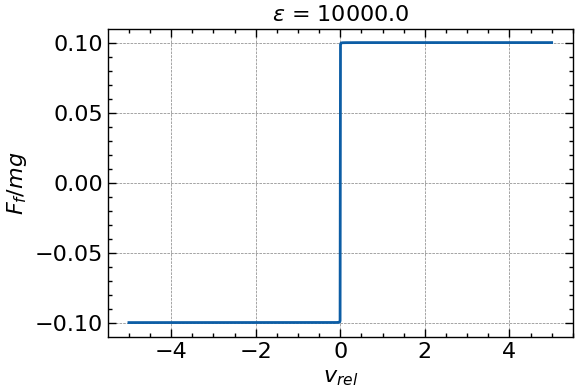

In [22]:
plt.figure(figsize = (6,4))
vel = np.linspace(-5, 5, 1000)
friction = (1/np.pi)*2*mu*np.arctan(eps*vel)
plt.plot(vel, friction)
plt.xlabel("$v_{rel}$")
plt.ylabel("$F_f/mg$")
plt.title(f'$\epsilon$ = {eps}')
plt.savefig(f'arc{eps}.pdf')
# plt.cla()
# plt.clf()
plt.show()

Read earthquake data and store it in a pandas dataframe

In [23]:
eq_name = 'tabas'
eq_type = 'near_fault'
if not os.path.exists(eq_name):
    os.mkdir(eq_name)
# file_name = eq_name + '.csv'

In [24]:
h1 = 'RSN143_TABAS_TAB-L1.AT2'
h2 = 'RSN143_TABAS_TAB-T1.AT2'
v = 'RSN143_TABAS_TAB-V1.AT2'

In [25]:
desc, nptsv, time_stepv, tv, vacc = processNGAfile(os.path.join(eq_type, v))
desc, npts, time_step, t, acc1 = processNGAfile(os.path.join(eq_type, h1))
desc, npts, time_step, t, eq_acc = processNGAfile(os.path.join(eq_type, h2))
if (np.max(acc1) > np.max(eq_acc)):
    eq_acc = acc1

In [26]:
t = tv if npts > nptsv else t
npt =  int(min(npts, nptsv))

Create dataframe

In [27]:
sol_length = vacc if npts > nptsv else eq_acc
df = pd.DataFrame(sol_length, index = t, columns = ['Acceleration(g)'])

Interpolate to create a continuous function

In [28]:
eq_f = interp1d(t, eq_acc, kind = 'linear')
veq_f = interp1d(tv, vacc, kind = 'linear')

Plot the interpolated earthquake data

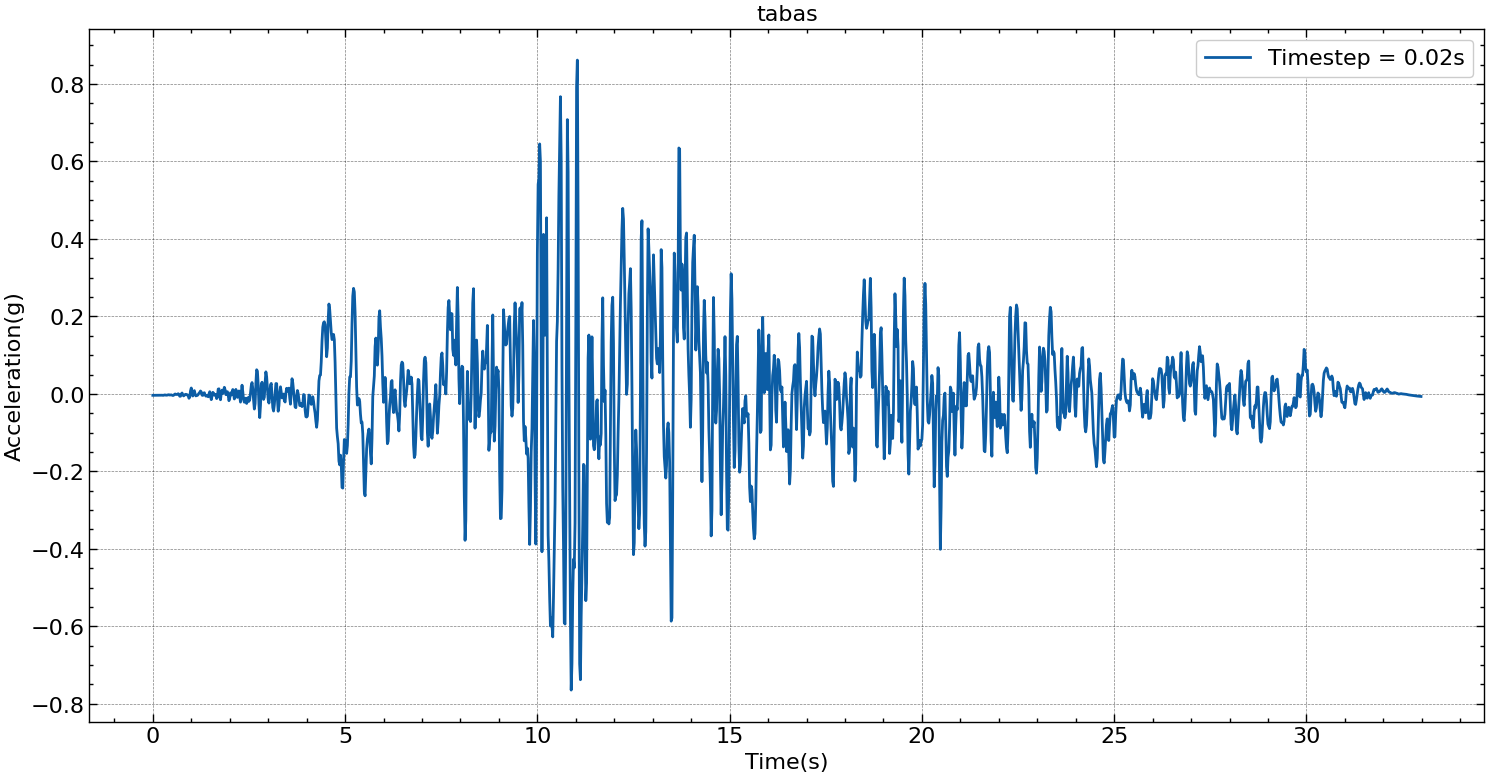

In [29]:
fig = plt.figure(figsize = (18,9))
ax = fig.add_subplot(111)
h1, = ax.plot(t, eq_acc)
ax.legend([h1], [f'Timestep = {time_step}s'])
ax.set_ylabel('Acceleration(g)')
ax.set_xlabel('Time(s)')
plt.title(eq_name)
plt.savefig(os.path.join(eq_name,'acc_time_history.png'))
plt.show()

Fourier Transform of Earthquake Record

In [30]:
N = len(eq_acc)

In [31]:
eq_fft = fft(eq_acc)
eq_fft = np.abs(eq_fft)[0:N//2]

In [32]:
frq = fftfreq(N,time_step)[0:N//2]

In [33]:
dom_freq = frq[np.argmax(eq_fft)]*2*np.pi

In [34]:
dominant_period = 1.0/frq[np.argmax(eq_fft)]
dominant_period

0.7857142857142857

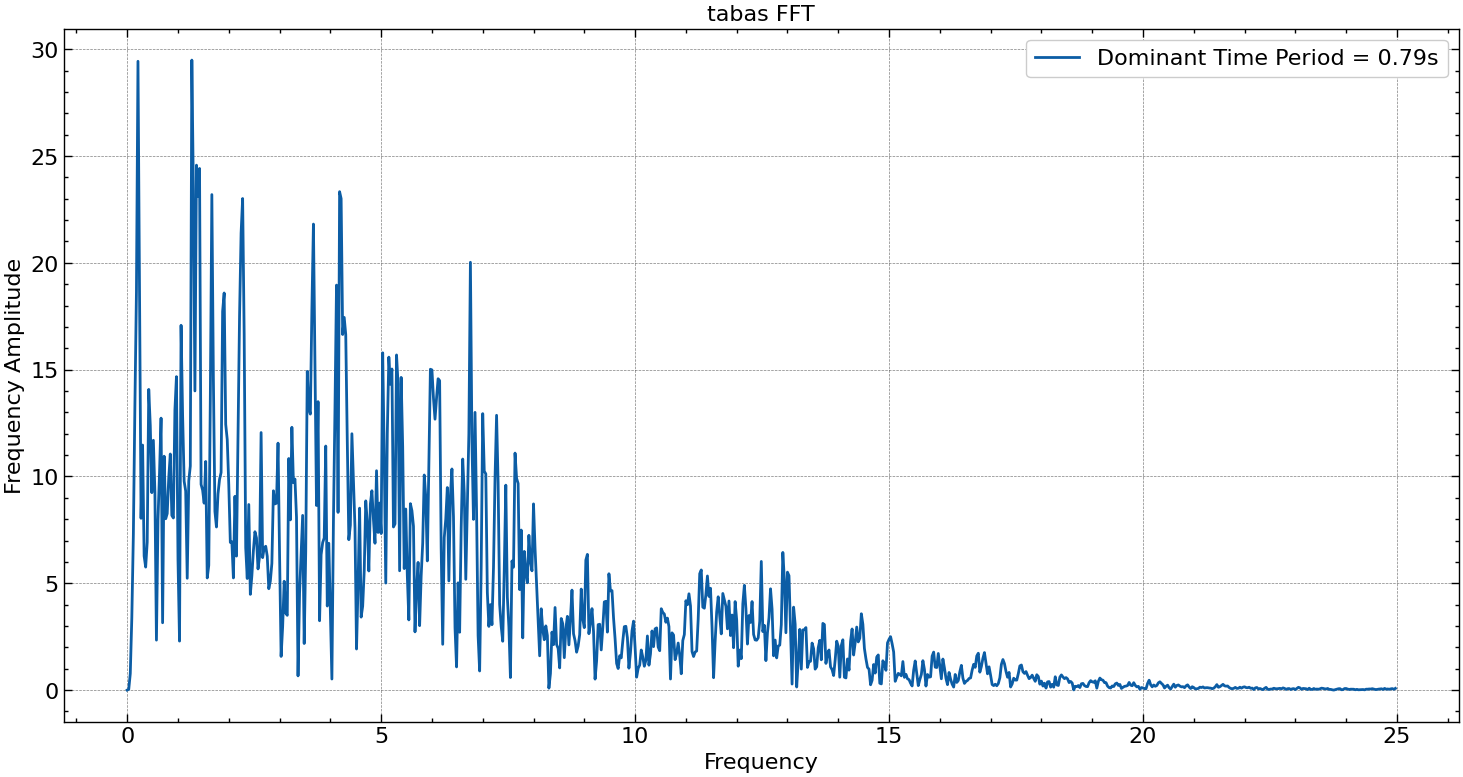

In [35]:
fig = plt.figure(figsize = (18,9))
ax = fig.add_subplot(111)
h1, = ax.plot(frq, eq_fft)
ax.set_ylabel('Frequency Amplitude')
ax.set_xlabel('Frequency')
ax.legend([h1], [f'Dominant Time Period = {dominant_period:.2f}s'])
plt.title(f"{eq_name} FFT")
plt.savefig(os.path.join(eq_name,'earthquake_fft.png'))
plt.show()

Implement functions for soil constants based on ASCE 4-16

In [36]:
# betax_f = interp1d([1.0, 1.5, 2.0, 3.0, 4.0], [0.5, 0.46, 0.46, 0.48, 0.5], kind='linear')
# betaphi_f = interp1d([1.0, 1.5, 2.0, 3.0, 4.0], [0.5, 0.55, 0.6, 0.69, 0.78], kind = 'linear')

In [37]:
# def soil_constants(B, L, poisson, shear_vel, density):
#     span_ratio = L/B
#     shear_modulus = shear_vel**2 * density
#     kx = 2*(1+poisson)*shear_modulus*betax_f(span_ratio)*np.sqrt(B*L)
#     kphi = (shear_modulus/(1-poisson))*betaphi_f(span_ratio)*B*L**2
#     Rx = np.sqrt(B*L/np.pi)
#     cx = 0.576*kx*Rx*np.sqrt(density/shear_modulus)
#     Rphi = (B*L**3 / (3*np.pi))**0.25
#     Bphi = 3*(1-poisson)*I / (8*density*Rphi**5)
#     cphi = (0.3/(1+Bphi))*kphi*Rphi*np.sqrt(density/shear_modulus)
#     return [kx, kphi, cx, cphi]

Implement functions for frequency-dependent soil spring constants based on [Gazetas 1991](http://ssi.civil.ntua.gr/downloads/journals/1991-ASCE_FORMULAS%20AND%20CHARTS%20FOR%20IMPEDANCES%20OF%20SURFACE%20AND%20EMBEDDED%20FOUNDATIONS.pdf)

In [38]:
def damp_rot_coeff(a0, span_ratio):
    dimless_freqs = np.linspace(0.0, 2.0, 21)
    coeff_lb_1 = np.array([0.0, 0.02, 0.03, 0.06, 0.1, 0.13, 0.16, 0.19, 0.23, 0.28, 0.32, 
                            0.35, 0.38, 0.40, 0.43, 0.47, 0.48, 0.49, 0.50, 0.52, 0.53])
    coeff_lb_2 = np.array([0.0, 0.07, 0.13, 0.18, 0.26, 0.34, 0.39, 0.43, 0.48, 0.53, 0.57, 
                            0.59, 0.62, 0.64, 0.68, 0.71, 0.72, 0.74, 0.76, 0.78, 0.79])
    # coeff_f = interp2d(x = dimless_freqs, y = [1.0, 2.0], z = [coeff_lb_1, coeff_lb_2], kind = 'linear')
    xx, yy = np.meshgrid(np.linspace(0.0, 2.0, 21), [1.0, 2.0])
    xxr = xx.flatten()
    yyr = yy.flatten()
    z = np.array([coeff_lb_1, coeff_lb_2])
    zzr = z.flatten()
    tck = bisplrep(xxr, yyr, zzr, kx=5, ky=5)
    ff = lambda xnew, ynew: bisplev(xnew, ynew, tck).T
    return ff(a0, span_ratio)

In [39]:
values = []
values2 = []
for i in range(0, 201, 10):
    # print(i/100)
    values.append(damp_rot_coeff(i/100, 1.0))
    values2.append(damp_rot_coeff(i/100, 2.0))

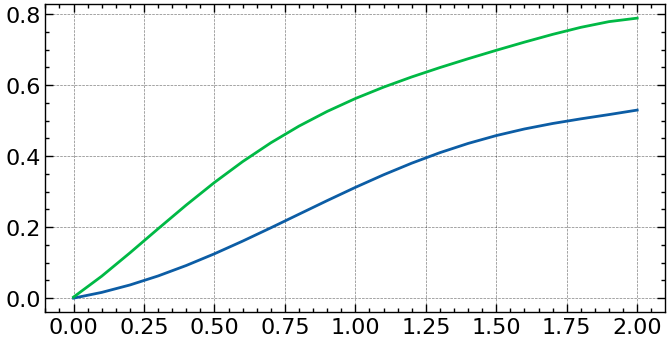

In [40]:
plt.figure(figsize = [8,4])
plt.plot(np.linspace(0.0, 2.0, 21), values)
plt.plot(np.linspace(0.0, 2.0, 21), values2)

In [41]:
def soil_constants_f(B, L, poisson, shear_vel, density, dom_freq):
    G = shear_vel**2 * density
    xi = B/(4.0 * L)
    Iby = 16.0 * B * L**3 / 12.0
    a0 = dom_freq * B / shear_vel
    Vla = 3.4 * shear_vel / (np.pi * (1 - poisson))
    Ky_static = (2 * G * L / (2 - poisson)) * (2 + 2.50 * xi**0.85)
    Kx_static = Ky_static - (0.2 / (0.75 - poisson)) * G*L * (1 - (B/L))
    Kx = Kx_static
    Cx = density * shear_vel * B * L
    Kphi_static = (3 * G / (1 - poisson)) * Iby**0.75 * (L/B)**0.25 * (2.4 + 0.5 * (B/L))
    Kphi = Kphi_static * (1 - 0.26 * a0)
    cry = damp_rot_coeff(a0, L/B)
    Cphi = density * Vla * Iby * cry
    return (Kx, Kphi, Cx, Cphi)

Define superstructure and isolator constants 

In [42]:
breadth , length , nu , vs, rho = 4.2, 4.8, 0.3, 100, 1800
mt, mb, mf, I = 4500.0, 9500.0, 5000.0, 90000.0
Ts, Tb, dampb, damps = 0.1, 1000000.0, 0.0, 0.05
# kt, kb, kh, kp = 1e9, 0.05e9, 1.072e9, 2.268e12
# ct, cb, ch, cp = 1.403e6, 4.712e5, 3.375e8, 2.202e11
kb = (mt + mb) * (2*np.pi/Tb) **2
cb = 2*dampb*(mt + mb)*2*np.pi/Tb
kt = mt * (2*np.pi/Ts) **2
ct = 2*dampb*mt*2*np.pi/Ts
kh, kp, ch, cp = soil_constants_f(breadth/2.0, length/2.0, nu, vs, rho, dom_freq)
# kh, kp, ch, cp = soil_constants(breadth, length, nu, vs, rho)
h = 2.45
delta = 1.0*np.pi/180.0
S0_init = [0,0,0,0,0,0,0,0]

In [43]:
[kt, kb, ct, cb]

[17765287.921960846, 5.526978464610042e-07, 0.0, 0.0]

Define soil constants

In [44]:
kp/kt

189.0655328322403

Solve the IVP for the interpolated earthquake data

In [45]:
def ground_acc_f(t):
    return eq_f(t)*g

In [46]:
def vertical_f(t):
    return veq_f(t)*g

In [84]:
def solve_eq(system, time_series, initial, earthquake, vertical):
    start, end = [time_series[0], time_series[-1]]
    ans = integrate.solve_ivp(system, (start,end), initial, method = 'LSODA', t_eval = time_series, 
                              args = (earthquake, vertical), rtol = 1e-8, atol = 1e-8)
    soln = ans.y
    dsdt = system(time_series, soln, earthquake, vertical)
    acc = np.stack((dsdt[1], dsdt[3], dsdt[5], dsdt[7]))
    return (soln, acc)

In [85]:
%%time
S0, acc = solve_eq(dSdt, t, S0_init, ground_acc_f, vertical_f)
# ans = integrate.solve_ivp(dSdt, (t[0],t[-1]), S0_init, method = 'BDF', t_eval = t, args = (ground_acc_f,), 
#                           rtol = 1e-8, atol = 1e-8)
# S0 = ans.y
# dsdt = dSdt(t, S0, ug_dd)
# acc = np.stack((dsdt[1], dsdt[3], dsdt[5], dsdt[7]))

CPU times: user 39.3 s, sys: 864 ms, total: 40.1 s
Wall time: 39.2 s


In [86]:
S0

array([[ 0.00000000e+00,  3.34684777e-06,  1.60753558e-05, ...,
         7.64374591e-01,  7.64369085e-01,  7.64364704e-01],
       [ 0.00000000e+00,  4.36980494e-04,  6.66384567e-04, ...,
        -1.37110150e-04, -3.30650340e-04, -5.75191511e-05],
       [ 0.00000000e+00,  6.20046795e-07,  1.32663187e-06, ...,
         7.64352693e-01,  7.64353502e-01,  7.64354274e-01],
       ...,
       [ 0.00000000e+00,  2.21048103e-04,  3.84928192e-05, ...,
         1.31325591e-05, -5.26369220e-05, -3.93141596e-05],
       [ 0.00000000e+00,  1.71247836e-08,  2.04767753e-07, ...,
         2.91172788e-07,  2.08551646e-07,  1.17194521e-07],
       [ 0.00000000e+00,  4.19495720e-06,  9.86459505e-06, ...,
        -4.67889705e-06, -3.89449840e-06, -1.23589962e-06]])

In [87]:
max_value = lambda arr: abs(arr).max()

Save the solution to csv files

In [88]:
# solution_arr = np.concatenate((df.values, S0.T, acc.T), axis=1)
# columns = ['earthquake', 'ut', 'vt', 'ub', 'vb', 'uo', 'vo', 'phi', 'omega', 'at', 'ab', 'ao', 'alpha']

In [89]:
# solution_df = pd.DataFrame(solution_arr, index = df.index, columns = columns)
# solution_df.to_csv(os.path.join(eq_name, 'solution.csv'))
# solution_df

In [90]:
times = np.array(t).reshape([npt, 1])

In [91]:
solution_arr = np.concatenate((times, S0.T, acc.T), axis=1)
columns = ['time (s)', 'ut', 'vt', 'ub', 'vb', 'uo', 'vo', 'phi', 'omega', 'at', 'ab', 'ao', 'alpha']

In [92]:
solution_df = pd.DataFrame(solution_arr, columns = columns)
solution_df.to_csv(os.path.join(eq_name, 'solution.csv'), index = None)
solution_df

,time (s),ut,vt,ub,vb,uo,vo,phi,omega,at,ab,ao,alpha
0,0.00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.482046,0.735755,-0.446107,0.000000
1,0.02,0.000003,0.000437,6.200468e-07,0.000034,0.000004,0.000221,1.712478e-08,0.000004,0.031715,0.000216,-0.008209,0.000673
2,0.04,0.000016,0.000666,1.326632e-06,0.000036,0.000006,0.000038,2.047678e-07,0.000010,-0.016745,0.000062,-0.004247,-0.000526
3,0.06,0.000023,-0.000080,2.061935e-06,0.000037,0.000007,0.000026,2.812542e-07,-0.000001,-0.044375,0.000015,-0.000720,-0.000418
4,0.08,0.000015,-0.000614,2.797381e-06,0.000036,0.000006,-0.000056,1.558890e-07,-0.000011,-0.004442,-0.000158,-0.005867,-0.000109
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1645,32.90,0.764364,0.000506,7.643511e-01,0.000038,0.000007,0.000077,1.742773e-07,0.000007,0.005118,0.000148,0.002894,-0.000349
1646,32.92,0.764373,0.000310,7.643519e-01,0.000040,0.000009,0.000086,2.731408e-07,0.000005,-0.021431,0.000107,-0.002053,-0.000020
1647,32.94,0.764375,-0.000137,7.643527e-01,0.000041,0.000010,0.000013,2.911728e-07,-0.000005,-0.019940,-0.000033,-0.004318,-0.000269
1648,32.96,0.764369,-0.000331,7.643535e-01,0.000040,0.000009,-0.000053,2.085516e-07,-0.000004,0.003986,-0.000104,-0.001596,-0.000240


In [93]:
drift = S0[0] - S0[2]
idr = drift / h *100
roof_acc = acc[0] + acc[2] + ground_acc_f(t)
max_idr = max_value(idr)
max_acc = max_value(roof_acc)
max_psd = max_value(S0[2])
peaks = {
    'idr': max_idr,
    'acc': max_acc,
    'psd': max_psd
}

In [94]:
peak_df = pd.DataFrame(peaks, index = ['peak'])
peak_df.to_csv(os.path.join(eq_name, 'peaks.csv'), index = None)

Plot the structural responses

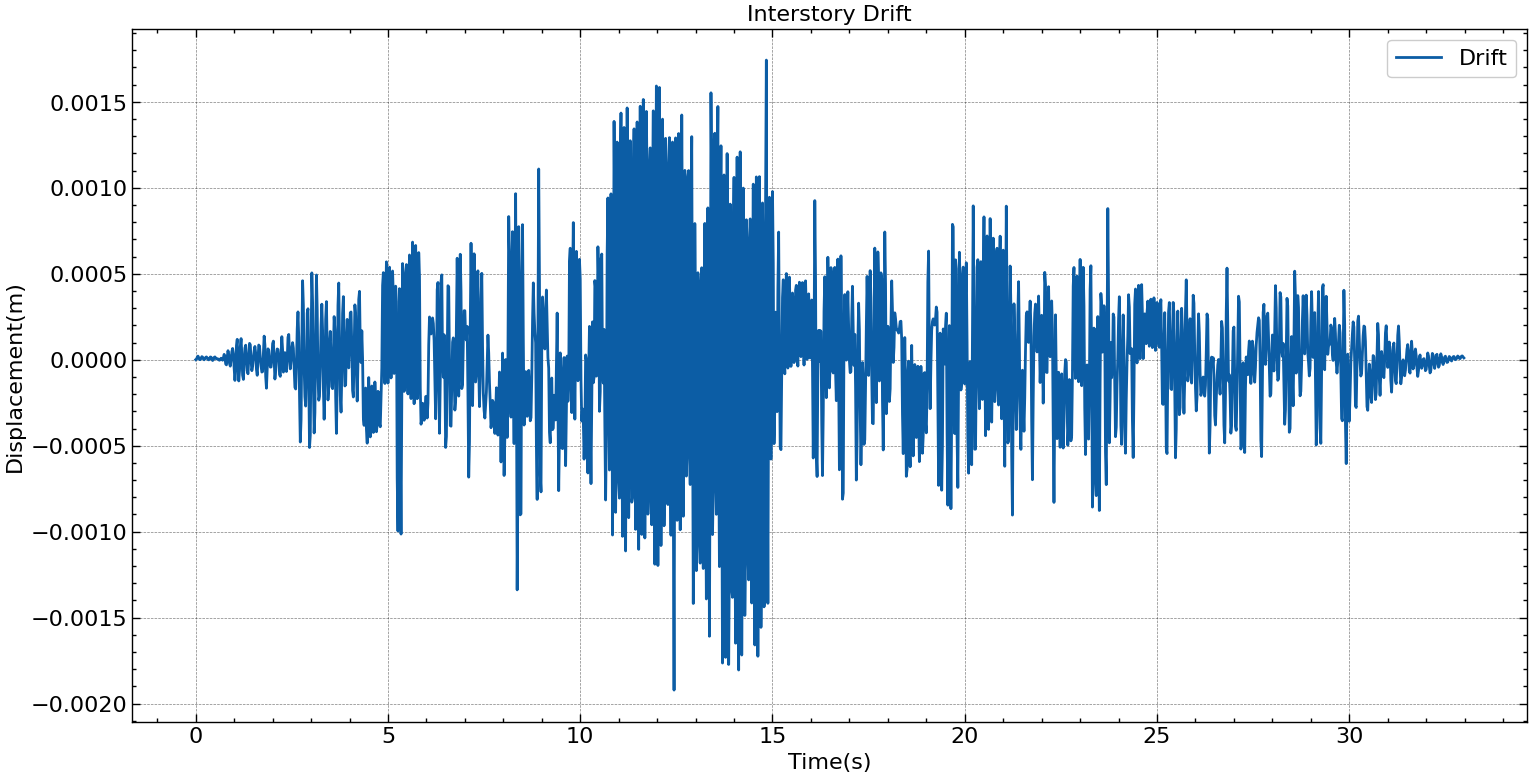

In [95]:
drift = S0[0] - S0[2]
fig = plt.figure(figsize = (18,9))
ax = fig.add_subplot(111)
h1, = ax.plot(t, drift)
ax.legend([h1, ], ['Drift', ])
ax.set_ylabel('Displacement(m)')
ax.set_xlabel('Time(s)')
plt.title('Interstory Drift')
plt.savefig(os.path.join(eq_name,'drift_response.png'))
plt.show()

In [96]:
abs_drift = np.absolute(drift)
drift_max = np.amax(abs_drift) * 1000
time_max = t[np.argmax(abs_drift)]
print(f'Max drift is {drift_max} mm at {time_max}s.') 

Max drift is 1.921118391875254 mm at 12.44s.


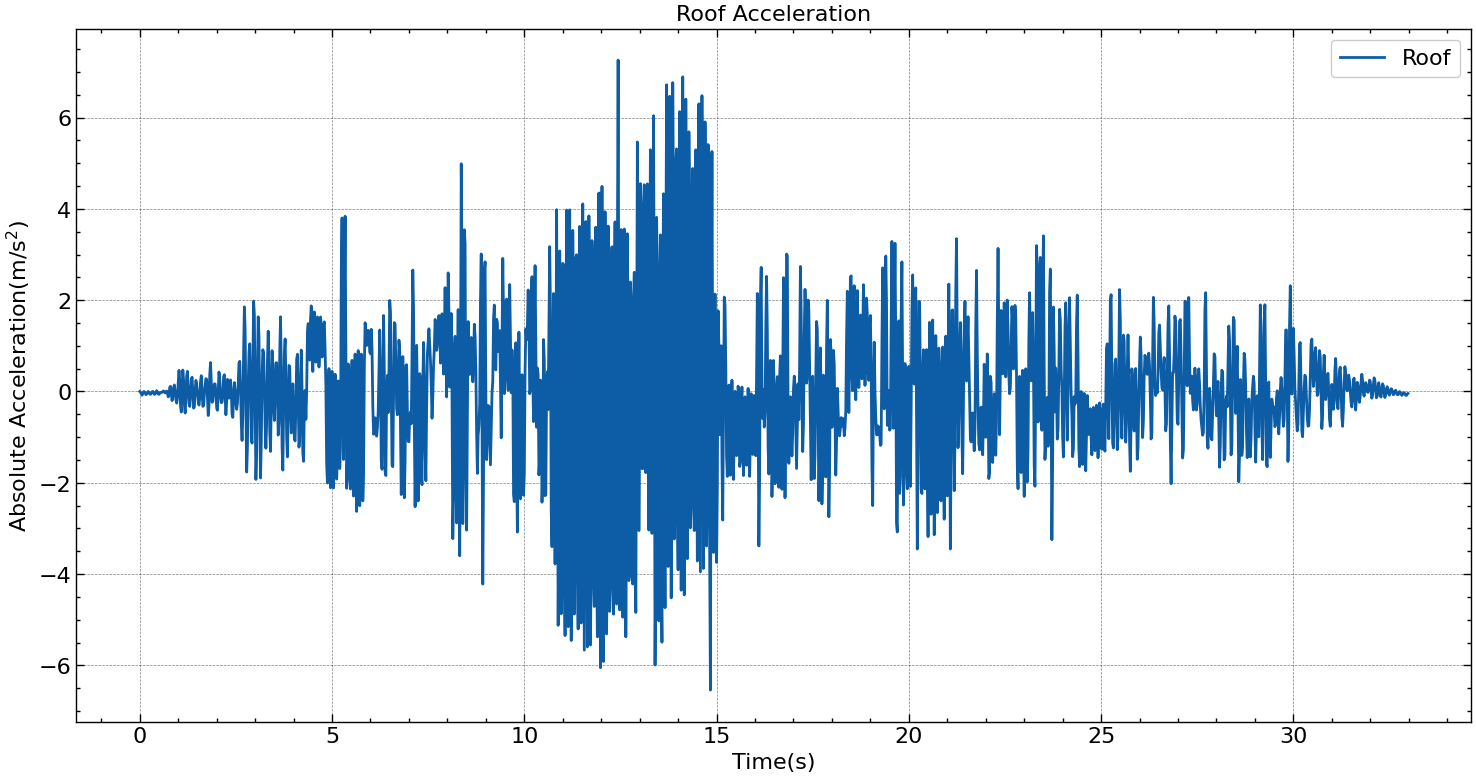

In [97]:
roof_acc = acc[0] + acc[2] + ground_acc_f(t)
fig = plt.figure(figsize = (18,9))
ax = fig.add_subplot(111)
h1, = ax.plot(t, roof_acc)
ax.legend([h1,], ['Roof',])
ax.set_xlabel('Time(s)')
ax.set_ylabel('Absolute Acceleration(m/s$^2$)')
plt.title('Roof Acceleration')
plt.savefig(os.path.join(eq_name,'roof_acc_response.png'))
plt.show()

In [98]:
abs_acc = np.absolute(roof_acc)
acc_max = np.amax(abs_acc)
time_max = t[np.argmax(abs_acc)]
print(f'Max acceleration is {acc_max} m/s\u00b2 at {time_max}s.') 

Max acceleration is 7.260315025579471 m/s² at 12.44s.


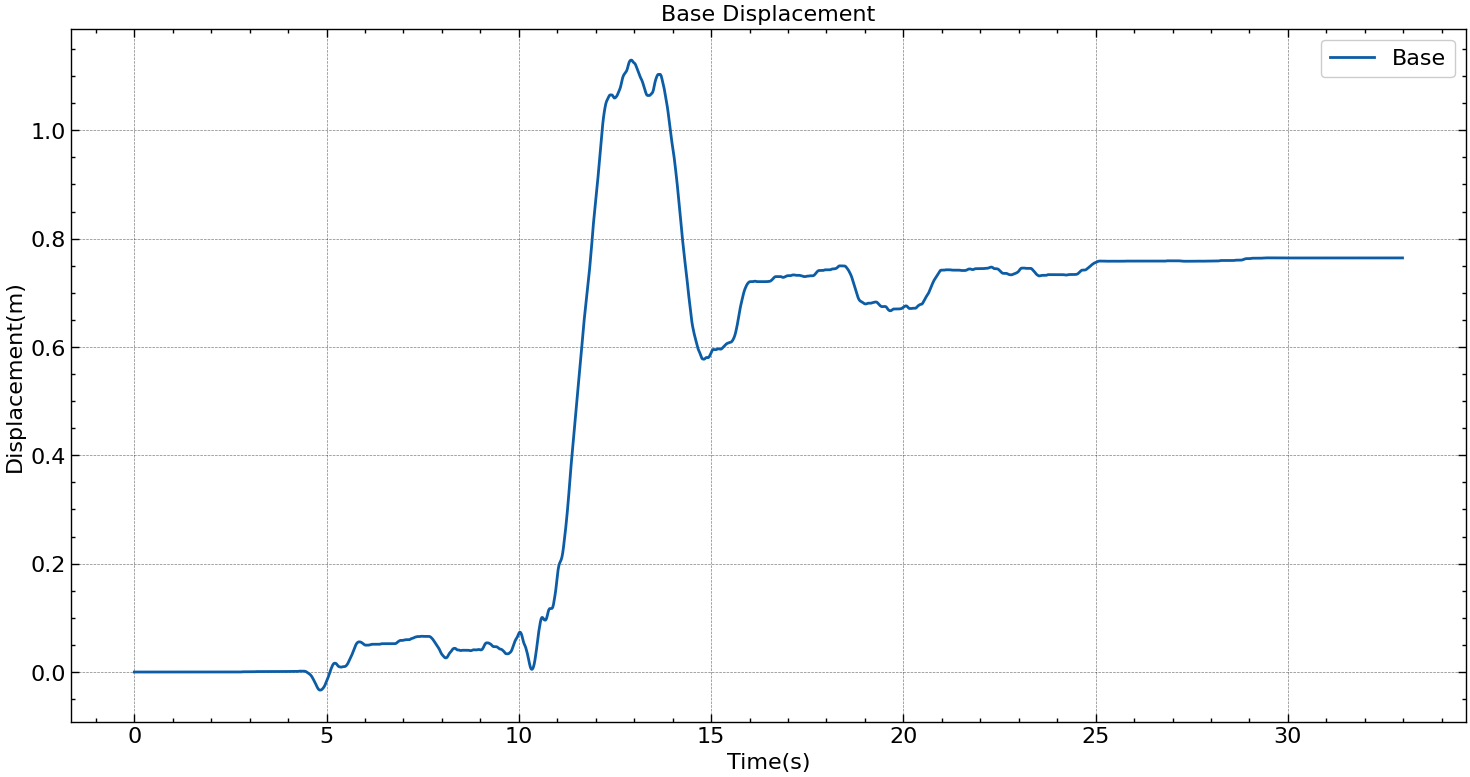

In [99]:
fig = plt.figure(figsize = (18,9))
ax = fig.add_subplot(111)
idx = int(30/time_step)
h2, = ax.plot(t, S0[2])
ax.legend([h2], ['Base'])
ax.set_ylabel('Displacement(m)')
ax.set_xlabel('Time(s)')
plt.title('Base Displacement')
plt.savefig(os.path.join(eq_name,'base_displacement.png'))
plt.show()

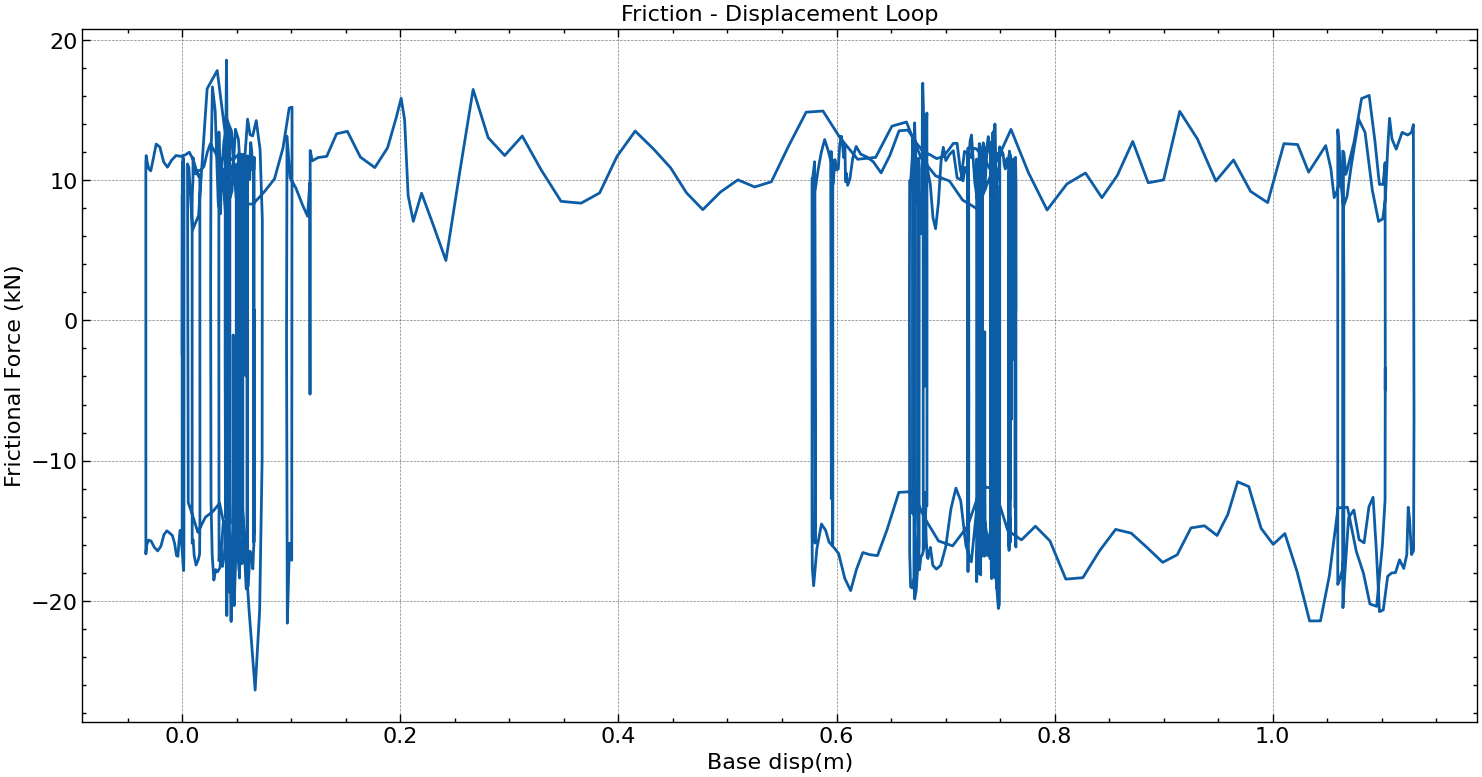

In [100]:
fig = plt.figure(figsize = (18,9))
ax = fig.add_subplot(111)
h1, = ax.plot(S0[2], -(mt*(acc[0] + acc[2] + h*acc[3] + ground_acc_f(t)) + mb* (acc[1] + acc[2] + ground_acc_f(t))) / 1000.0)
# ax.legend([h2], ['Base'])
ax.set_ylabel('Frictional Force (kN)')
ax.set_xlabel('Base disp(m)')
plt.title('Friction - Displacement Loop')
plt.savefig(os.path.join(eq_name,'base_displacement.png'))
plt.show()

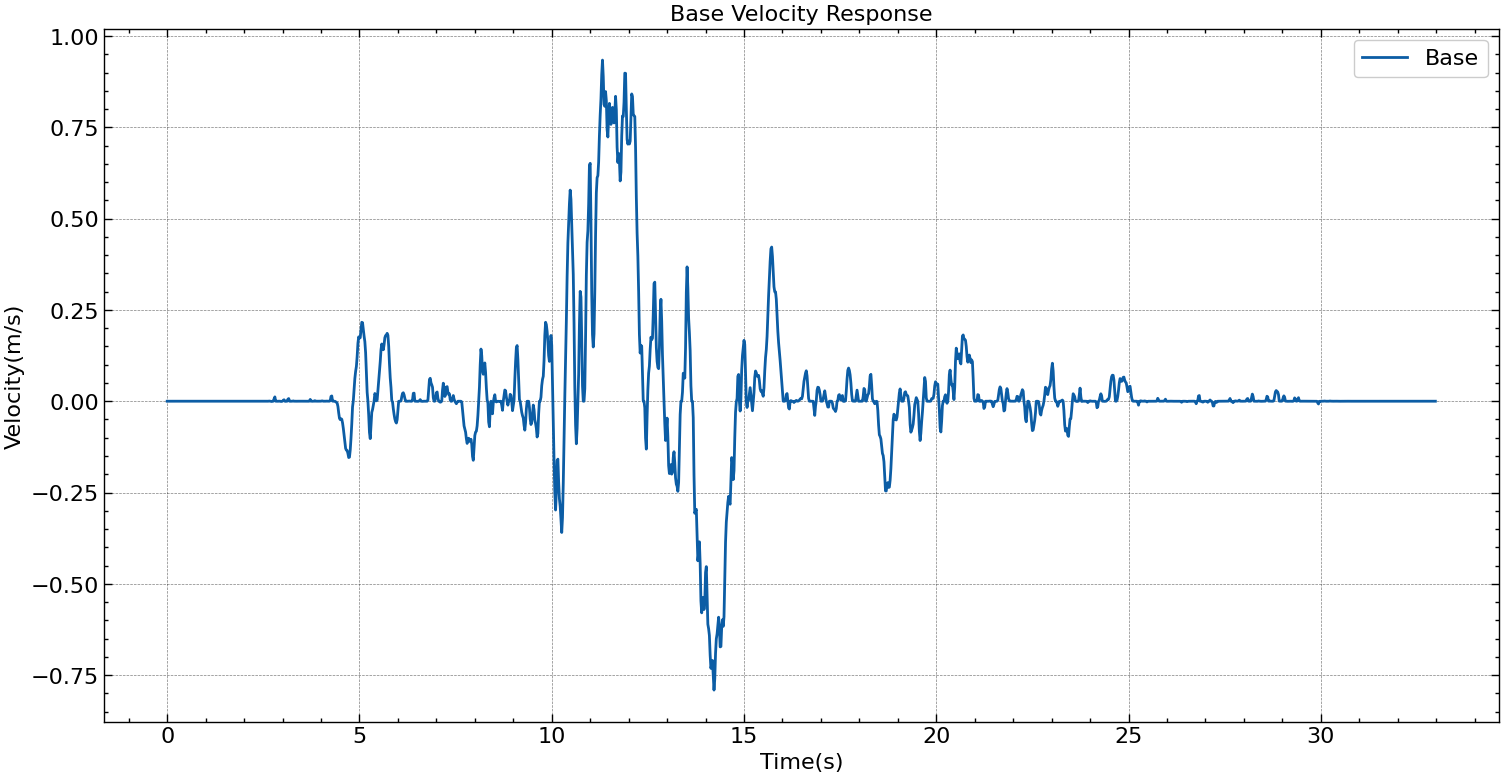

In [101]:
fig = plt.figure(figsize = (18,9))
ax = fig.add_subplot(111)
h2, = ax.plot(t, S0[3])
ax.legend([h2], ['Base'])
ax.set_ylabel('Velocity(m/s)')
ax.set_xlabel('Time(s)')
plt.title('Base Velocity Response')
plt.savefig(os.path.join(eq_name,'base_vel_response.png'))
plt.show()

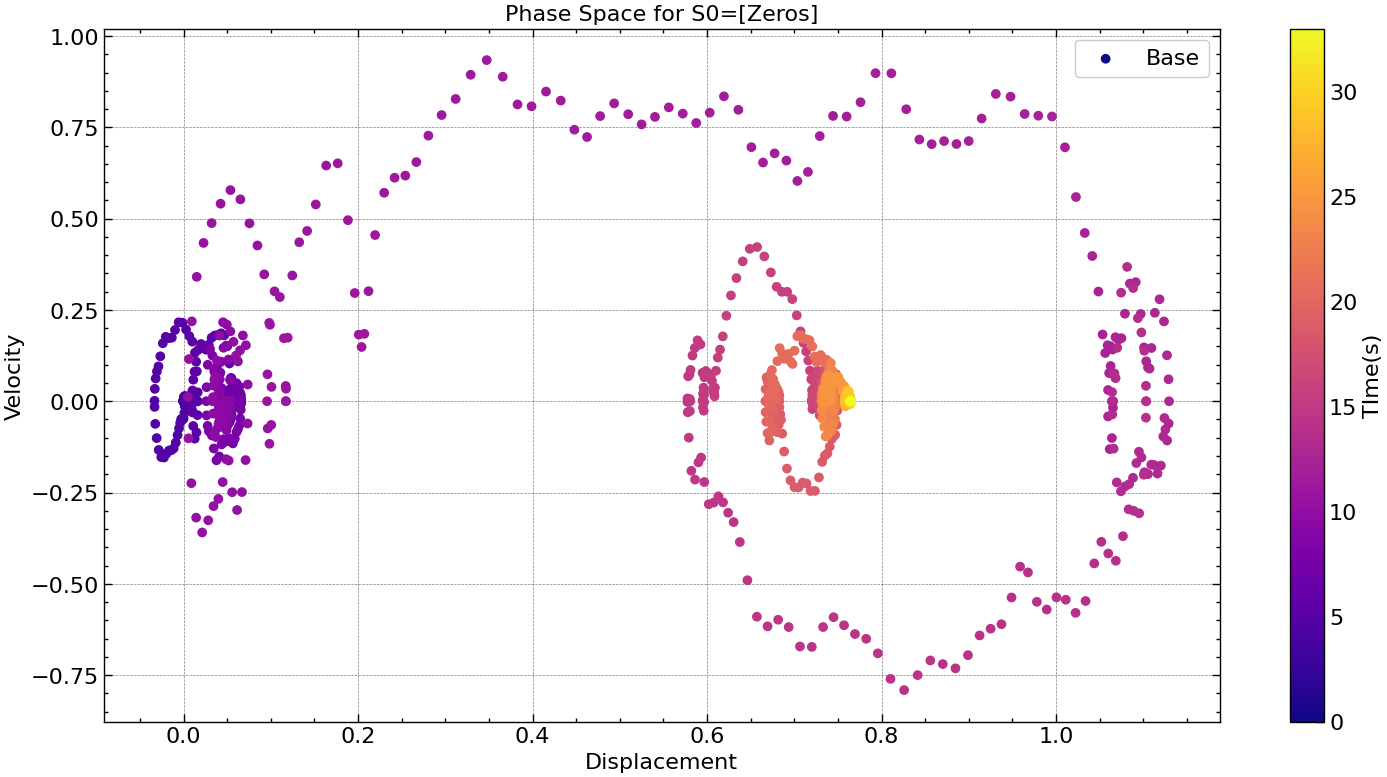

In [102]:
fig = plt.figure(figsize = (18,9))
ax = fig.add_subplot(111)
h1 = ax.scatter(S0[2], S0[3], c = t, cmap = 'plasma')
# ax.plot(S0[2], S0[3])
ax.legend([h1, ], ['Base', ])
ax.set_ylabel('Velocity')
ax.set_xlabel('Displacement')
plt.title('Phase Space for S0=[Zeros]')
plt.colorbar(h1, label = 'TIme(s)')
plt.show()

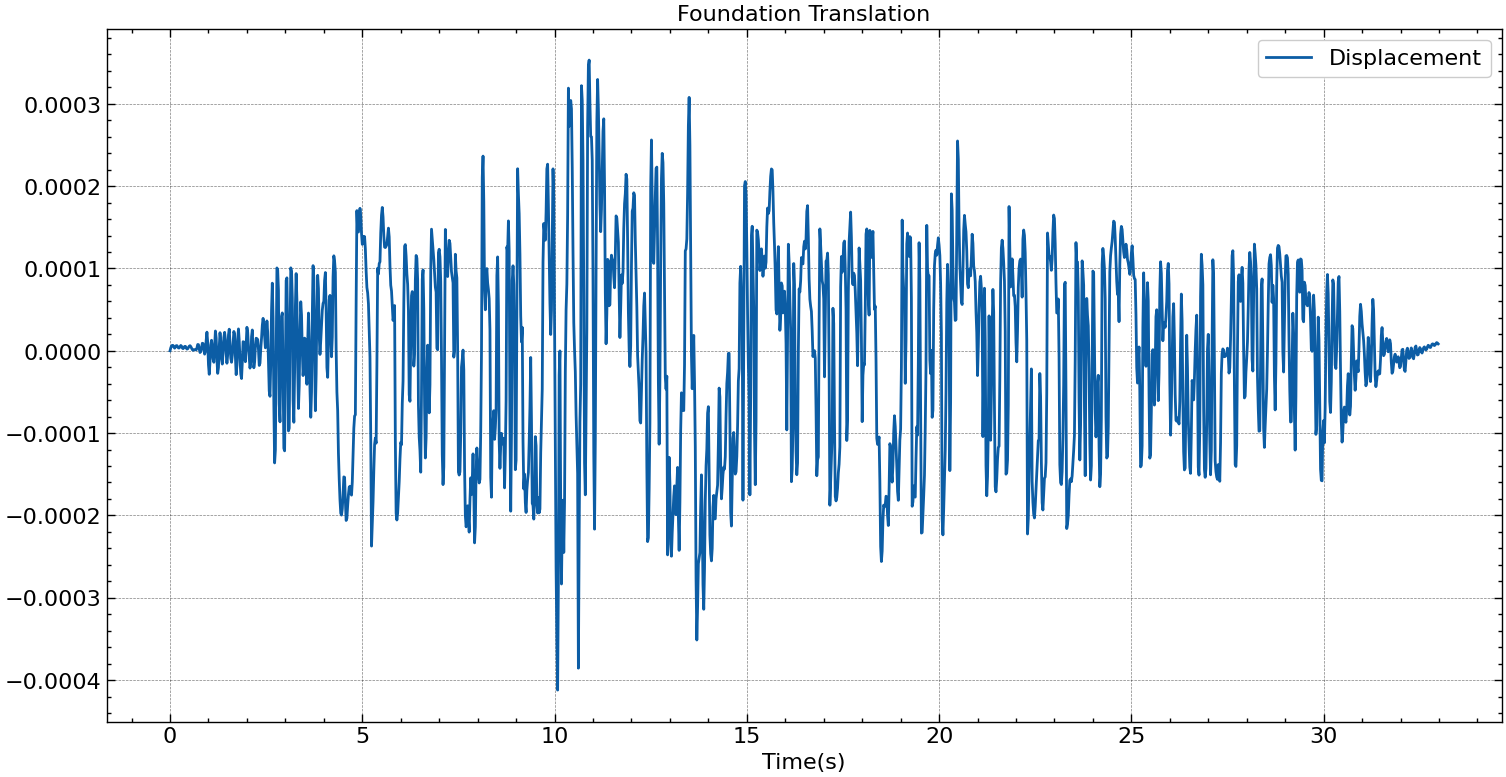

In [103]:
fig = plt.figure(figsize = (18,9))
ax = fig.add_subplot(111)
h1, = ax.plot(t, S0[4])
ax.legend([h1, ], ['Displacement', ])
ax.set_xlabel('Time(s)')
plt.title('Foundation Translation')
plt.savefig(os.path.join(eq_name,'foundation_translation.png'))
plt.show()

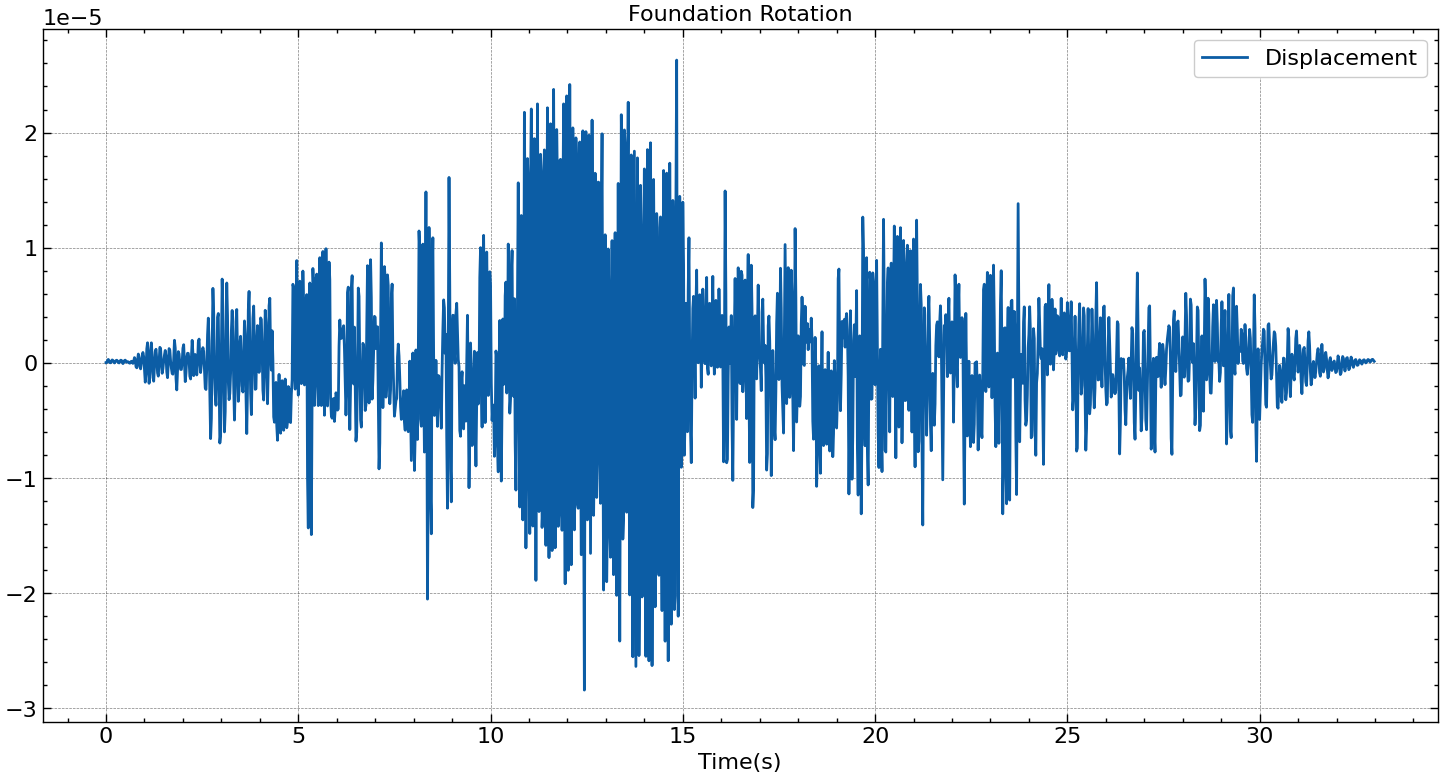

In [104]:
fig = plt.figure(figsize = (18,9))
ax = fig.add_subplot(111)
h1, = ax.plot(t, S0[6])
ax.legend([h1,], ['Displacement',])
ax.set_xlabel('Time(s)')
plt.title('Foundation Rotation')
plt.savefig(os.path.join(eq_name,'foundation_rotation.png'))
plt.show()

## Scaling

In [105]:
max_value(eq_f(t))

0.8617591

In [106]:
solutions = np.zeros(shape = (10, 8, len(df)))
accels = np.zeros(shape = (10, 4, len(df)))
eq_scaled = np.zeros(shape = (10, 1, len(df)))
max_drifts = np.zeros(10)
max_accels = np.zeros(10)
max_disps = np.zeros(10)

In [108]:
%%time
eq_data = eq_f(t) 
for i in range(10):
    eqs = eq_data/max_value(eq_data)*(i+1)/10
    eq_interp = interp1d(t, eqs, kind = 'linear')
    eqs_f = lambda t: eq_interp(t) * g
    solutions[i], accels[i] = solve_eq(dSdt, t, S0_init, eqs_f, vertical_f)
    eq_scaled[i] = eqs
    max_drifts[i] = max_value(solutions[i,0] - solutions[i,2])
    max_accels[i] = max_value(accels[i,0] + accels[i,2] + eqs*g)
    max_disps[i] = max_value(solutions[i,2])

CPU times: user 5min 55s, sys: 5 s, total: 6min
Wall time: 5min 54s


In [ ]:
eq_scaled[9,0,250]/df.values[250]

In [ ]:
factors = np.arange(0.1, 1.1, 0.1).round(1)
factors

In [ ]:
np.shape(solutions[0])

In [ ]:
for i,v in enumerate(factors):
    directory = os.path.join(eq_name, str(v))
    if not os.path.exists(directory):
        os.mkdir(directory)
    solution_arr = np.concatenate((eq_scaled[i].T, solutions[i].T, accels[i].T), axis=1)
    columns = ['earthquake', 'ut', 'vt', 'ub', 'vb', 'uo', 'vo', 'phi', 'omega', 'at', 'ab', 'ao', 'alpha']
    solution_df = pd.DataFrame(solution_arr, index = df.index, columns = columns)
    solution_df.to_csv(os.path.join(directory, 'solution.csv'))
    peaks = {'idr': max_drifts[i]/h*100, 'acc': max_accels[i], 'psd': max_disps[i]}
    peak_df = pd.DataFrame(peaks, index = ['peak'])
    peak_df.to_csv(os.path.join(directory, 'peaks.csv'), index = None)

In [ ]:
fig = plt.figure(figsize = (18,9))
ax = fig.add_subplot(111)
h1 = ax.plot(factors, max_drifts/h*100, '^--', ms = 10.0)
ax.set_xlabel('Peak Scaled Acceleration(g)')
ax.set_ylabel('Interstory Drift (%)')
plt.title('Paramteric Study - PGA vs IDR')
plt.savefig(os.path.join(eq_name,'pga_vs_idr.png'))
plt.show()

In [ ]:
fig = plt.figure(figsize = (18,9))
ax = fig.add_subplot(111)
h1 = ax.plot(factors, max_accels, '^--', ms = 10.0)
ax.set_xlabel('Peak Scaled Acceleration(g)')
ax.set_ylabel('Peak Roof Acceleration (m/s\u00b2)')
plt.title('Paramteric Study - PGA vs Roof Acceleration')
plt.savefig(os.path.join(eq_name,'pga_vs_roof_acc.png'))
plt.show()

In [ ]:
fig = plt.figure(figsize = (18,9))
ax = fig.add_subplot(111)
h1 = ax.plot(factors, max_disps, '^--', ms = 10.0)
ax.set_xlabel('Peak Scaled Acceleration(g)')
ax.set_ylabel('Peak Base Displacement (m)')
plt.title('Paramteric Study - PGA vs Base Displacement')
plt.savefig(os.path.join(eq_name,'pga_vs_base_disp.png'))
plt.show()

## Fixed Base

Find the response for fixed base building by assuming $\mu = 1000$. Construct a state-space vector $S1$ similar to $S0$

In [ ]:
mu = 1000
S1_init = [0,0,0,0,0,0,0,0]

In [ ]:
S1, acc1 = solve_eq(dSdt, t, S1_init, ground_acc_f, vertical_f)

Save the solution to csv

In [ ]:
solution_arr = np.concatenate((df.values, S1.T, acc1.T), axis=1)
solution_df = pd.DataFrame(solution_arr, index = df.index, columns = columns)
solution_df.to_csv(os.path.join(eq_name, 'solution_fixed_base.csv'))

In [ ]:
drift_fix = S1[0] - S1[2]
idr_fix = drift_fix / h *100
roof_acc_fix = acc1[0] + acc1[2] + ground_acc_f(t)
max_idr = max_value(idr_fix)
max_acc = max_value(roof_acc_fix)
max_psd = max_value(S1[2])
peaks = {
    'idr': max_idr,
    'acc': max_acc,
    'psd': max_psd
}

In [ ]:
peak_df = pd.DataFrame(peaks, index = ['peak'])
peak_df.to_csv(os.path.join(eq_name, 'peaks_fixed_base.csv'), index = None)

Plot the response of fixed base building and compare it with base isolated building

In [ ]:
fig = plt.figure(figsize = (18,9))
ax = fig.add_subplot(111)
h1, = ax.plot(t, drift_fix)
h2, = ax.plot(t, S1[2], color = 'red')
ax.legend([h1, h2], ['Drift', 'Base'])
ax.set_ylabel('Displacement(m)')
ax.set_xlabel('Time(s)')
plt.title('Displacement Response')
plt.show()

In [ ]:
fig = plt.figure(figsize = (18,9))
ax = fig.add_subplot(111)
h1, = ax.plot(t, drift_fix, color = 'red')
h2, = ax.plot(t, drift)
ax.legend([h1, h2], ['Fixed Base', 'Base Isolated'])
ax.set_ylabel('Drift(m)')
ax.set_xlabel('Time(s)')
plt.title('Drift Comparision')
plt.savefig(os.path.join(eq_name,'fix_compare_drift.png'))
plt.show()

In [ ]:
abs_drift_fix = np.absolute(drift_fix)
drift_max_fix = np.amax(abs_drift_fix) * 1000
time_max = t[np.argmax(abs_drift_fix)]
reduce = (drift_max_fix - drift_max)/drift_max_fix * 100
print(f'Max drift is {drift_max_fix} mm at {time_max}s. {reduce:.2f}% reduction of max drift is observed')

In [ ]:
fig = plt.figure(figsize = (18,9))
ax = fig.add_subplot(111)
h1, = ax.plot(t, roof_acc_fix, color = 'red')
h2, = ax.plot(t, roof_acc)
ax.legend([h1, h2], ['Fixed Base', 'Base Isolated'])
ax.set_ylabel('Absolute Acceleration(m/s$^2$)')
ax.set_xlabel('Time(s)')
plt.title('Roof Acceleration Comparision')
plt.savefig(os.path.join(eq_name,'fix_compare_roof_acc.png'))
plt.show()

In [ ]:
abs_acc_fix = np.absolute(roof_acc_fix)
acc_max_fix = np.amax(abs_acc_fix)
time_max = t[np.argmax(abs_acc_fix)]
reduce = (acc_max_fix - acc_max)/acc_max_fix * 100
print(f'Max acceleration is {acc_max_fix} m/s\u00b2 at {time_max}s. {reduce:.2f}% reduction of max acceleration is observed') 

Save solutions to csv after scaling

In [ ]:
solutions1 = np.zeros(shape = (10, 8, len(df)))
accels1 = np.zeros(shape = (10, 4, len(df)))
eq_scaled1 = np.zeros(shape = (10, 1, len(df)))
max_drifts1 = np.zeros(10)
max_accels1 = np.zeros(10)
max_disps1 = np.zeros(10)

In [ ]:
eq_data = eq_f(t) 
for i in range(10):
    eqs = eq_data/max_value(eq_data)*(i+1)/10
    eq_interp = interp1d(t, eqs, kind = 'linear')
    eqs_f = lambda t: eq_interp(t) * g
    solutions1[i], accels1[i] = solve_eq(dSdt, t, S1_init, eqs_f, vertical_f)
    eq_scaled1[i] = eqs
    max_drifts1[i] = max_value(solutions1[i,0] - solutions1[i,2])
    max_accels1[i] = max_value(accels1[i,0] + accels1[i,2] + eqs*g)
    max_disps1[i] = max_value(solutions1[i,2])

In [ ]:
for i,v in enumerate(factors):
    directory = os.path.join(eq_name, str(v))
    if not os.path.exists(directory):
        os.mkdir(directory)
    solution_arr = np.concatenate((eq_scaled1[i].T, solutions1[i].T, accels1[i].T), axis=1)
    columns = ['earthquake', 'ut', 'vt', 'ub', 'vb', 'uo', 'vo', 'phi', 'omega', 'at', 'ab', 'ao', 'alpha']
    solution_df = pd.DataFrame(solution_arr, index = df.index, columns = columns)
    solution_df.to_csv(os.path.join(directory, 'solution_fixed_base.csv'))
    peaks = {'idr': max_drifts1[i]/h*100, 'acc': max_accels1[i], 'psd': max_disps1[i]}
    peak_df = pd.DataFrame(peaks, index = ['peak'])
    peak_df.to_csv(os.path.join(directory, 'peaks_fixed_base.csv'), index = None)

Plot the parametric curves

In [ ]:
fig = plt.figure(figsize = (18,9))
ax = fig.add_subplot(111)
h1, = ax.plot(factors, max_drifts1/h*100, '^--', ms = 10.0)
h2, = ax.plot(factors, max_drifts/h*100, '^--', ms = 10.0)
ax.legend([h1, h2], ['Fixed Base', 'Base Isolated'])
ax.set_xlabel('Peak Scaled Acceleration(g)')
ax.set_ylabel('Interstory Drift (%)')
plt.title('Paramteric Study - PGA vs IDR')
plt.savefig(os.path.join(eq_name,'fix_compare_pga_vs_idr.png'))
plt.show()

In [ ]:
fig = plt.figure(figsize = (18,9))
ax = fig.add_subplot(111)
h1, = ax.plot(factors, max_accels1, '^--', ms = 10.0)
h2, = ax.plot(factors, max_accels, '^--', ms = 10.0)
ax.legend([h1, h2], ['Fixed Base', 'Base Isolated'])
ax.set_xlabel('Peak Scaled Acceleration(g)')
ax.set_ylabel('Peak Roof Acceleration (m/s\u00b2)')
plt.title('Paramteric Study - PGA vs Roof Acceleration')
plt.savefig(os.path.join(eq_name,'fix_compare_pga_vs_roof_acc.png'))
plt.show()

In [ ]:
fig = plt.figure(figsize = (18,9))
ax = fig.add_subplot(111)
h1, = ax.plot(factors, max_disps1, '^--', ms = 10.0)
h2, = ax.plot(factors, max_disps, '^--', ms = 10.0)
ax.legend([h1, h2], ['Fixed Base', 'Base Isolated'])
ax.set_xlabel('Peak Scaled Acceleration(g)')
ax.set_ylabel('Peak Base Displacement (m)')
plt.title('Paramteric Study - PGA vs Base Displacement')
plt.savefig(os.path.join(eq_name,'fix_compare_pga_vs_base_disp.png'))
plt.show()

## Without SSI

In [ ]:
mu = 0.1
S2_init = [0,0,0,0,0,0,0,0]
vs = 5500
kh, kp, ch, cp = soil_constants_f(breadth/2.0, length/2.0, nu, vs, rho, dom_freq)

In [ ]:
kh, kp, ch, cp

In [ ]:
S2, acc2 = solve_eq(dSdt, t, S2_init, ground_acc_f, vertical_f)

Save solution to csv

In [ ]:
solution_arr = np.concatenate((df.values, S2.T, acc2.T), axis=1)
solution_df = pd.DataFrame(solution_arr, index = df.index, columns = columns)
solution_df.to_csv(os.path.join(eq_name, 'solution_no_ssi.csv'))

In [ ]:
drift_ssi = S2[0] - S2[2]
idr_ssi = drift_ssi / h *100
roof_acc_ssi = acc2[0] + acc2[2] + ground_acc_f(t)
max_idr = max_value(idr_ssi)
max_acc = max_value(roof_acc_ssi)
max_psd = max_value(S2[2])
peaks = {
    'idr': max_idr,
    'acc': max_acc,
    'psd': max_psd
}

In [ ]:
peak_df = pd.DataFrame(peaks, index = ['peak'])
peak_df.to_csv(os.path.join(eq_name, 'peaks_no_ssi.csv'), index = None)

Plot the responses and compare it to response with SSI

In [ ]:
fig = plt.figure(figsize = (18,9))
ax = fig.add_subplot(111)
idx = int(30/time_step)
h1, = ax.plot(t, S2[2])
h2, = ax.plot(t, S2[4])
ax.legend([h1, h2], ['Base', 'Foundation'])
ax.set_xlabel('Time(s)')
ax.set_ylabel('Displacement(m)')
plt.title('Base vs Foundation Displacement')
plt.show()

In [ ]:
fig = plt.figure(figsize = (18,9))
ax = fig.add_subplot(111)
h1, = ax.plot(t, drift_ssi, color = 'red')
h2, = ax.plot(t, drift)
ax.legend([h1, h2], ['Without SSI', 'With SSI'])
ax.set_ylabel('Drift(m)')
ax.set_xlabel('Time(s)')
plt.title('Drift Comparision')
plt.savefig(os.path.join(eq_name,'ssi_compare_drift.png'))
plt.show()

In [ ]:
fig = plt.figure(figsize = (18,9))
ax = fig.add_subplot(111)
h1, = ax.plot(t, roof_acc_ssi, color = 'red')
h2, = ax.plot(t, roof_acc)
ax.legend([h1, h2], ['Without SSI', 'With SSI'])
ax.set_ylabel('Absolute Acceleration(m/s$^2$)')
ax.set_xlabel('Time(s)')
plt.title('Roof Acceleration Comparision')
plt.savefig(os.path.join(eq_name,'ssi_compare_roof_acc.png'))
plt.show()

Save solutions to csv after scaling

In [ ]:
solutions2 = np.zeros(shape = (10, 8, len(df)))
accels2 = np.zeros(shape = (10, 4, len(df)))
eq_scaled2 = np.zeros(shape = (10, 1, len(df)))
max_drifts2 = np.zeros(10)
max_accels2 = np.zeros(10)
max_disps2 = np.zeros(10)

In [ ]:
eq_data = eq_f(t) 
for i in range(10):
    eqs = eq_data/max_value(eq_data)*(i+1)/10
    eq_interp = interp1d(t, eqs, kind = 'linear')
    eqs_f = lambda t: eq_interp(t) * g
    solutions2[i], accels2[i] = solve_eq(dSdt, t, S1_init, eqs_f, vertical_f)
    eq_scaled2[i] = eqs
    max_drifts2[i] = max_value(solutions2[i,0] - solutions2[i,2])
    max_accels2[i] = max_value(accels2[i,0] + accels2[i,2] + eqs*g)
    max_disps2[i] = max_value(solutions2[i,2])

In [ ]:
for i,v in enumerate(factors):
    directory = os.path.join(eq_name, str(v))
    if not os.path.exists(directory):
        os.mkdir(directory)
    solution_arr = np.concatenate((eq_scaled2[i].T, solutions2[i].T, accels2[i].T), axis=1)
    columns = ['earthquake', 'ut', 'vt', 'ub', 'vb', 'uo', 'vo', 'phi', 'omega', 'at', 'ab', 'ao', 'alpha']
    solution_df = pd.DataFrame(solution_arr, index = df.index, columns = columns)
    solution_df.to_csv(os.path.join(directory, 'solution_no_ssi.csv'))
    peaks = {'idr': max_drifts2[i]/h*100, 'acc': max_accels2[i], 'psd': max_disps2[i]}
    peak_df = pd.DataFrame(peaks, index = ['peak'])
    peak_df.to_csv(os.path.join(directory, 'peaks_no_ssi.csv'), index = None)

Plot the parametric curves

In [ ]:
fig = plt.figure(figsize = (18,9))
ax = fig.add_subplot(111)
h1, = ax.plot(factors, max_drifts2/h*100, '^--', ms = 10.0)
h2, = ax.plot(factors, max_drifts/h*100, 'r^--', ms = 10.0)
ax.legend([h1, h2], ['Without SSI', 'With SSI'])
ax.set_xlabel('Peak Scaled Acceleration(g)')
ax.set_ylabel('Interstory Drift (%)')
plt.title('Paramteric Study - PGA vs IDR')
plt.savefig(os.path.join(eq_name,'ssi_compare_pga_vs_idr.png'))
plt.show()

In [ ]:
fig = plt.figure(figsize = (18,9))
ax = fig.add_subplot(111)
h1, = ax.plot(factors, max_accels2, '^--', ms = 10.0)
h2, = ax.plot(factors, max_accels, 'r^--', ms = 10.0)
ax.legend([h1, h2], ['Without SSI', 'With SSI'])
ax.set_xlabel('Peak Scaled Acceleration(g)')
ax.set_ylabel('Peak Roof Acceleration (m/s\u00b2)')
plt.title('Paramteric Study - PGA vs Roof Acceleration')
plt.savefig(os.path.join(eq_name,'ssi_compare_pga_vs_roof_acc.png'))
plt.show()

In [ ]:
fig = plt.figure(figsize = (18,9))
ax = fig.add_subplot(111)
h1, = ax.plot(factors, max_disps2, '^--', ms = 10.0)
h2, = ax.plot(factors, max_disps, 'r^--', ms = 10.0)
ax.legend([h1, h2], ['Without SSI', 'With SSI'])
ax.set_xlabel('Peak Scaled Acceleration(g)')
ax.set_ylabel('Peak Base Displacement (m)')
plt.title('Paramteric Study - PGA vs Base Displacement')
plt.savefig(os.path.join(eq_name,'ssi_compare_pga_vs_base_disp.png'))
plt.show()

## Parametric Study against Shear Wave Velocity

In [ ]:
velocities = (100, 150, 200, 250, 300, 350, 400, 450, 500)
num_vels = len(velocities)

In [ ]:
solutions = np.zeros(shape = (num_vels, 8, len(df)))
accels = np.zeros(shape = (num_vels, 4, len(df)))
max_drifts = np.zeros(num_vels)
max_accels = np.zeros(num_vels)
max_disps = np.zeros(num_vels)

In [ ]:
for i in range(num_vels):
    vs = velocities[i]
    kh, kp, ch, cp = soil_constants_f(breadth/2.0, length/2.0, nu, vs, rho, dom_freq)
    solutions[i], accels[i] = solve_eq(dSdt, t, S0_init, ground_acc_f, vertical_f)
    max_drifts[i] = max_value(solutions[i,0] - solutions[i,2])
    max_accels[i] = max_value(accels[i,0] + accels[i,2] + ground_acc_f(t))
    max_disps[i] = max_value(solutions[i,2])

In [ ]:
shear_wave_folder = os.path.join(eq_name, 'shear_wave_velocities')
if not os.path.exists(shear_wave_folder):
        os.mkdir(shear_wave_folder)
for i, v in enumerate(velocities):
    directory = os.path.join(eq_name, 'shear_wave_velocities', str(v))
    if not os.path.exists(directory):
        os.mkdir(directory)
    solution_arr = np.concatenate((df.values, solutions[i].T, accels[i].T), axis=1)
    columns = ['earthquake', 'ut', 'vt', 'ub', 'vb', 'uo', 'vo', 'phi', 'omega', 'at', 'ab', 'ao', 'alpha']
    solution_df = pd.DataFrame(solution_arr, index = df.index, columns = columns)
    solution_df.to_csv(os.path.join(directory, 'solution.csv'))
    peaks = {'idr': max_drifts[i]/h*100, 'acc': max_accels[i], 'psd': max_disps[i]}
    peak_df = pd.DataFrame(peaks, index = ['peak'])
    peak_df.to_csv(os.path.join(directory, 'peaks.csv'), index = None)

Plot the parametric curves

In [ ]:
fig = plt.figure(figsize = (18,9))
ax = fig.add_subplot(111)
h1, = ax.plot(velocities, max_drifts/h*100, '^--', ms = 10.0)
ax.legend([h1, ], ['$T_s = 0.5$s, $\mu = 0.1$'])
ax.set_xlabel('Shear Wave Velocity(m/s)')
ax.set_ylabel('Interstory Drift (%)')
plt.title('Paramteric Study - Shear wave velocity vs IDR')
plt.savefig(os.path.join(eq_name,'shearwave_vs_idr.png'))
plt.show()

In [ ]:
fig = plt.figure(figsize = (18,9))
ax = fig.add_subplot(111)
h1, = ax.plot(velocities, max_accels, '^--', ms = 10.0)
ax.legend([h1, ], ['$T_s = 0.5$s, $\mu = 0.1$'])
ax.set_xlabel('Shear Wave Velocity(m/s)')
ax.set_ylabel('Peak Roof Acceleration (m/s\u00b2)')
plt.title('Paramteric Study - Shear wave velocity vs Roof Acceleration')
plt.savefig(os.path.join(eq_name,'shearwave_vs_roof_acc.png'))
plt.show()

In [ ]:
fig = plt.figure(figsize = (18,9))
ax = fig.add_subplot(111)
h1, = ax.plot(velocities, max_disps, '^--', ms = 10.0)
ax.legend([h1, ], ['$T_s = 0.5$s, $\mu = 0.1$'])
ax.set_xlabel('Shear Wave Velocity(m/s)')
ax.set_ylabel('Peak Base Displacement (m)')
plt.title('Paramteric Study - Shear wave velocity vs Base Displacement')
plt.savefig(os.path.join(eq_name,'shearwave_vs_base_disp.png'))
plt.show()

## Without inclination

In [ ]:
mu = 0.1
S3_init = [0,0,0,0,0,0,0,0]
vs = 100.0
delta = 0.0
kh, kp, ch, cp = soil_constants_f(breadth/2.0, length/2.0, nu, vs, rho, dom_freq)

In [ ]:
kh, kp, ch, cp

In [ ]:
S3, acc3 = solve_eq(dSdt, t, S3_init, ground_acc_f, vertical_f)

Save solution to csv

In [ ]:
solution_arr = np.concatenate((df.values, S3.T, acc3.T), axis=1)
solution_df = pd.DataFrame(solution_arr, index = df.index, columns = columns)
solution_df.to_csv(os.path.join(eq_name, 'solution_no_angle.csv'))

In [ ]:
drift_angle = S3[0] - S3[2]
idr_angle = drift_angle / h *100
roof_acc_angle = acc3[0] + acc3[2] + ground_acc_f(t)
max_idr = max_value(idr_angle)
max_acc = max_value(roof_acc_angle)
max_psd = max_value(S3[2])
peaks = {
    'idr': max_idr,
    'acc': max_acc,
    'psd': max_psd
}

In [ ]:
peak_df = pd.DataFrame(peaks, index = ['peak'])
peak_df.to_csv(os.path.join(eq_name, 'peaks_no_angle.csv'), index = None)

Plot the responses and compare it to response with inclination

In [ ]:
fig = plt.figure(figsize = (18,9))
ax = fig.add_subplot(111)
idx = int(30/time_step)
h1, = ax.plot(t, S0[2])
h2, = ax.plot(t, S3[2])
ax.legend([h1, h2], ['Angle 1$\degree$', 'Angle 0$\degree$'])
ax.set_xlabel('Time(s)')
ax.set_ylabel('Base Displacement(m)')
plt.title('Base Displacement Comparison')
plt.savefig(os.path.join(eq_name,'angle_compare_disp.png'))
plt.show()

In [ ]:
fig = plt.figure(figsize = (18,9))
ax = fig.add_subplot(111)
h1, = ax.plot(t, drift_angle, color = 'red')
h2, = ax.plot(t, drift)
ax.legend([h1, h2], ['Without Inclination', 'With Inclination'])
ax.set_ylabel('Drift(m)')
ax.set_xlabel('Time(s)')
plt.title('Drift Comparision')
plt.savefig(os.path.join(eq_name,'angle_compare_drift.png'))
plt.show()

In [ ]:
fig = plt.figure(figsize = (18,9))
ax = fig.add_subplot(111)
h1, = ax.plot(t, roof_acc_angle, color = 'red')
h2, = ax.plot(t, roof_acc)
ax.legend([h1, h2], ['Without Inclination', 'With Inclination'])
ax.set_ylabel('Absolute Acceleration(m/s$^2$)')
ax.set_xlabel('Time(s)')
plt.title('Roof Acceleration Comparision')
plt.savefig(os.path.join(eq_name,'angle_compare_roof_acc.png'))
plt.show()

## Parametric Study against Inclination Angle

In [ ]:
angles = [-1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5]
num_angles = len(angles)
radians = map(np.radians, angles)

In [ ]:
radians

In [ ]:
# for i, angle in enumerate(radians):
#     print(i, '\n', angle)

In [ ]:
solutions = np.zeros(shape = (num_angles, 8, len(df)))
accels = np.zeros(shape = (num_angles, 4, len(df)))
max_drifts = np.zeros(num_angles)
max_accels = np.zeros(num_angles)
max_disps = np.zeros(num_angles)

In [ ]:
for i, angle in enumerate(radians):
    delta = angle
    # kh, kp, ch, cp = soil_constants_f(breadth, length, nu, vs, rho, dom_freq)
    solutions[i], accels[i] = solve_eq(dSdt, t, S0_init, ground_acc_f, vertical_f)
    max_drifts[i] = max_value(solutions[i,0] - solutions[i,2])
    max_accels[i] = max_value(accels[i,0] + accels[i,2] + ground_acc_f(t))
    max_disps[i] = max_value(solutions[i,2])

In [ ]:
angle_folder = os.path.join(eq_name, 'inclinations')
if not os.path.exists(angle_folder):
        os.mkdir(angle_folder)
for i, angle in enumerate(angles):
    directory = os.path.join(eq_name, 'inclinations', str(angle))
    if not os.path.exists(directory):
        os.mkdir(directory)
    solution_arr = np.concatenate((df.values, solutions[i].T, accels[i].T), axis=1)
    columns = ['earthquake', 'ut', 'vt', 'ub', 'vb', 'uo', 'vo', 'phi', 'omega', 'at', 'ab', 'ao', 'alpha']
    solution_df = pd.DataFrame(solution_arr, index = df.index, columns = columns)
    solution_df.to_csv(os.path.join(directory, 'solution.csv'))
    peaks = {'idr': max_drifts[i]/h*100, 'acc': max_accels[i], 'psd': max_disps[i]}
    peak_df = pd.DataFrame(peaks, index = ['peak'])
    peak_df.to_csv(os.path.join(directory, 'peaks.csv'), index = None)

Plot the parametric curves

In [ ]:
fig = plt.figure(figsize = (18,9))
ax = fig.add_subplot(111)
h1, = ax.plot(angles, max_drifts/h*100, '^--', ms = 10.0)
ax.legend([h1, ], ['$T_s = 0.1$s, $\mu = 0.1$'])
ax.set_xlabel('Inclination ($\degree$)')
ax.set_ylabel('Interstory Drift (%)')
plt.title('Paramteric Study - Inclination angle vs IDR')
plt.savefig(os.path.join(eq_name,'angle_vs_idr.png'))
plt.show()

In [ ]:
fig = plt.figure(figsize = (18,9))
ax = fig.add_subplot(111)
h1, = ax.plot(angles, max_accels, '^--', ms = 10.0)
ax.legend([h1, ], ['$T_s = 0.1$s, $\mu = 0.1$'])
ax.set_xlabel('Inclination Angle ($\degree$)')
ax.set_ylabel('Peak Roof Acceleration (m/s\u00b2)')
plt.title('Paramteric Study - Inclination Angle vs Roof Acceleration')
plt.savefig(os.path.join(eq_name,'angle_vs_roof_acc.png'))
plt.show()

In [ ]:
fig = plt.figure(figsize = (18,9))
ax = fig.add_subplot(111)
h1, = ax.plot(angles, max_disps, '^--', ms = 10.0)
ax.legend([h1, ], [f'$T_s$ = 0.1s, $\mu = 0.1$'])
ax.set_xlabel('Inclination Angle ($\degree$)')
ax.set_ylabel('Peak Base Displacement (m)')
plt.title('Paramteric Study - Inclination Angle vs Base Displacement')
plt.savefig(os.path.join(eq_name,'angle_vs_base_disp.png'))
plt.show()

## Without Vertical GM

In [ ]:
mu = 0.1
S4_init = [0,0,0,0,0,0,0,0]
vs = 100.0
delta = 1.0
kh, kp, ch, cp = soil_constants_f(breadth/2.0, length/2.0, nu, vs, rho, dom_freq)

In [ ]:
def vertical_f(t):
    return veq_f(t)*0.0

In [ ]:
S4, acc4 = solve_eq(dSdt, t, S4_init, ground_acc_f, vertical_f)

Save solution to csv

In [ ]:
solution_arr = np.concatenate((df.values, S4.T, acc4.T), axis=1)
solution_df = pd.DataFrame(solution_arr, index = df.index, columns = columns)
solution_df.to_csv(os.path.join(eq_name, 'solution_no_vert.csv'))

In [ ]:
drift_angle = S4[0] - S4[2]
idr_angle = drift_angle / h *100
roof_acc_angle = acc4[0] + acc4[2] + ground_acc_f(t)
max_idr = max_value(idr_angle)
max_acc = max_value(roof_acc_angle)
max_psd = max_value(S4[2])
peaks = {
    'idr': max_idr,
    'acc': max_acc,
    'psd': max_psd
}

In [ ]:
peak_df = pd.DataFrame(peaks, index = ['peak'])
peak_df.to_csv(os.path.join(eq_name, 'peaks_no_vert.csv'), index = None)

Plot the responses and compare it to response with inclination

In [ ]:
fig = plt.figure(figsize = (18,9))
ax = fig.add_subplot(111)
idx = int(30/time_step)
h1, = ax.plot(t, S0[2])
h2, = ax.plot(t, S4[2])
ax.legend([h1, h2], ['Without vertical GM', 'With vertical GM'])
ax.set_xlabel('Time(s)')
ax.set_ylabel('Base Displacement(m)')
plt.title('Base Displacement Comparison')
plt.savefig(os.path.join(eq_name,'vert_compare_disp.png'))
plt.show()

In [ ]:
fig = plt.figure(figsize = (18,9))
ax = fig.add_subplot(111)
h1, = ax.plot(t, drift_angle, color = 'red')
h2, = ax.plot(t, drift)
ax.legend([h1, h2], ['Without Vertical GM', 'With Vertical GM'])
ax.set_ylabel('Drift(m)')
ax.set_xlabel('Time(s)')
plt.title('Drift Comparision')
plt.savefig(os.path.join(eq_name,'vert_compare_drift.png'))
plt.show()

In [ ]:
fig = plt.figure(figsize = (18,9))
ax = fig.add_subplot(111)
h1, = ax.plot(t, roof_acc_angle, color = 'red')
h2, = ax.plot(t, roof_acc)
ax.legend([h1, h2], ['Without Vertical GM', 'With Vertical GM'])
ax.set_ylabel('Absolute Acceleration(m/s$^2$)')
ax.set_xlabel('Time(s)')
plt.title('Roof Acceleration Comparision')
plt.savefig(os.path.join(eq_name,'vert_compare_roof_acc.png'))
plt.show()

### Scaling

In [ ]:
solutions2 = np.zeros(shape = (10, 8, len(df)))
accels2 = np.zeros(shape = (10, 4, len(df)))
eq_scaled2 = np.zeros(shape = (10, 1, len(df)))
max_drifts2 = np.zeros(10)
max_accels2 = np.zeros(10)
max_disps2 = np.zeros(10)

In [ ]:
eq_data = eq_f(t) 
for i in range(10):
    eqs = eq_data/max_value(eq_data)*(i+1)/10
    eq_interp = interp1d(t, eqs, kind = 'linear')
    eqs_f = lambda t: eq_interp(t) * g
    solutions2[i], accels2[i] = solve_eq(dSdt, t, S1_init, eqs_f, vertical_f)
    eq_scaled2[i] = eqs
    max_drifts2[i] = max_value(solutions2[i,0] - solutions2[i,2])
    max_accels2[i] = max_value(accels2[i,0] + accels2[i,2] + eqs*g)
    max_disps2[i] = max_value(solutions2[i,2])

In [ ]:
for i,v in enumerate(factors):
    directory = os.path.join(eq_name, str(v))
    if not os.path.exists(directory):
        os.mkdir(directory)
    solution_arr = np.concatenate((eq_scaled2[i].T, solutions2[i].T, accels2[i].T), axis=1)
    columns = ['earthquake', 'ut', 'vt', 'ub', 'vb', 'uo', 'vo', 'phi', 'omega', 'at', 'ab', 'ao', 'alpha']
    solution_df = pd.DataFrame(solution_arr, index = df.index, columns = columns)
    solution_df.to_csv(os.path.join(directory, 'solution_no_vert.csv'))
    peaks = {'idr': max_drifts2[i]/h*100, 'acc': max_accels2[i], 'psd': max_disps2[i]}
    peak_df = pd.DataFrame(peaks, index = ['peak'])
    peak_df.to_csv(os.path.join(directory, 'peaks_no_vert.csv'), index = None)

Plot the parametric curves

In [ ]:
fig = plt.figure(figsize = (18,9))
ax = fig.add_subplot(111)
h1, = ax.plot(factors, max_drifts2/h*100, '^--', ms = 10.0)
h2, = ax.plot(factors, max_drifts/h*100, 'r^--', ms = 10.0)
ax.legend([h1, h2], ['Without Vertical GM', 'With Vertical GM'])
ax.set_xlabel('Peak Scaled Acceleration(g)')
ax.set_ylabel('Interstory Drift (%)')
plt.title('Paramteric Study - PGA vs IDR')
plt.savefig(os.path.join(eq_name,'vert_compare_pga_vs_idr.png'))
plt.show()

In [ ]:
fig = plt.figure(figsize = (18,9))
ax = fig.add_subplot(111)
h1, = ax.plot(factors, max_accels2, '^--', ms = 10.0)
h2, = ax.plot(factors, max_accels, 'r^--', ms = 10.0)
ax.legend([h1, h2], ['Without Vertical GM', 'With Vertical GM'])
ax.set_xlabel('Peak Scaled Acceleration(g)')
ax.set_ylabel('Peak Roof Acceleration (m/s\u00b2)')
plt.title('Paramteric Study - PGA vs Roof Acceleration')
plt.savefig(os.path.join(eq_name,'vert_compare_pga_vs_roof_acc.png'))
plt.show()

In [ ]:
fig = plt.figure(figsize = (18,9))
ax = fig.add_subplot(111)
h1, = ax.plot(factors, max_disps2, '^--', ms = 10.0)
h2, = ax.plot(factors, max_disps, 'r^--', ms = 10.0)
ax.legend([h1, h2], ['Without Vertical GM', 'With Vertical GM'])
ax.set_xlabel('Peak Scaled Acceleration(g)')
ax.set_ylabel('Peak Base Displacement (m)')
plt.title('Paramteric Study - PGA vs Base Displacement')
plt.savefig(os.path.join(eq_name,'vert_compare_pga_vs_base_disp.png'))
plt.show()